# Email classification with embeddings

In this notebook, emails are clasified to two categories: messages that require a response, and messages that don't. The second category includes thank you and confirmation -messages among other.

In [10]:
import string
import re 
import numpy as np
import pandas as pd
import gensim
import sklearn
import collections
import spacy
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [3]:
# Load data
df = pd.read_excel("en_email_dataset.xlsx")
df.head()

,message,correct_class
0,"Cliff Good luck and more importantly, have fun...",1
1,"Jan, Thank you for all of your help!! Lindy",1
2,Thank you for your help in chasing down the ma...,1
3,You are correct and it has been changed. Thank...,1
4,"Thank you very much for your help. Best, Jeff",1


In [6]:
df.shape

(3443, 2)

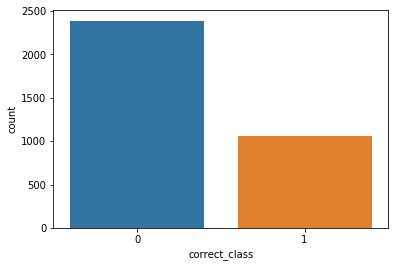

In [9]:
ax = sns.countplot(x="correct_class", data=df)

## Baseline model

This algorithm is the benchmark classifier that utilizes sklearn's pipeline to count the words in a dataset, performs tfidf-transforming, and classifies using SGD-classifier.

In [52]:
# Build pipeline
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                        ('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=0.0001, max_iter=1000, random_state=42))])


# Train model
x_train, x_test, y_train, y_test = train_test_split(df["message"], df['correct_class'], random_state = 0)
text_clf = text_clf.fit(x_train, y_train)

# Perform analysis
predicted = text_clf.predict(x_test)
print("Accuracy: {}".format(round(np.mean(predicted == y_test),2)))
report = sklearn.metrics.classification_report(predicted, y_test)
print(report)

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       627
           1       0.93      0.98      0.95       234

    accuracy                           0.97       861
   macro avg       0.96      0.98      0.97       861
weighted avg       0.98      0.97      0.97       861



## Embeddings

### GloVe

In [43]:
from gensim.models import KeyedVectors
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [45]:
print(glove_model.most_similar("sir")[0])
print(glove_model.most_similar("help")[0])
print(glove_model.most_similar("need")[0])
print(glove_model.most_similar("file")[0])
print(glove_model.most_similar("attachment")[0])
print(glove_model.most_similar("service")[0])
print(glove_model.most_similar("support")[0])
print(glove_model.most_similar("meeting")[0])

('mr', 0.7017468214035034)
('need', 0.8208699226379395)
('get', 0.889103889465332)
('files', 0.806323766708374)
('sensitivity', 0.6831309199333191)
('services', 0.8550636768341064)
('supporting', 0.8092236518859863)
('meet', 0.7461632490158081)


### Custom

In [28]:
email_list = list()
emails = df["message"].values.tolist()
stop_words = set(stopwords.words("english"))

In [29]:
# Preprocessing 
for email in emails:
    tokens = word_tokenize(email)
    # lowercase
    tokens = [w.lower() for w in tokens]
    # remove puctuation
    table = str.maketrans("","",string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic tokens
    words = [word for word in stripped if word.isalpha()]
    # remove stopwords
    words = [w for w in words if not w in stop_words]
    email_list.append(words)

In [46]:
# Build word2vec model
custom_model = gensim.models.Word2Vec(sentences=email_list, size=100, window=5, workers=4, min_count=2, iter=100)

In [47]:
print(custom_model.most_similar("sir")[0])
print(custom_model.most_similar("help")[0])
print(custom_model.most_similar("need")[0])
print(custom_model.most_similar("file")[0])
print(custom_model.most_similar("attachment")[0])
print(custom_model.most_similar("service")[0])
print(custom_model.most_similar("support")[0])
print(custom_model.most_similar("meeting")[0])

('otto', 0.7762136459350586)
('casa', 0.47884416580200195)
('kobra', 0.4627636969089508)
('june', 0.6477605104446411)
('harry', 0.6248341798782349)
('palmnet', 0.7408140897750854)
('court', 0.714199423789978)
('board', 0.6633205413818359)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: Depre

In [50]:
w2v = dict(zip(custom_model.wv.index2word, custom_model.wv.syn0))
print(len(w2v))
model.save("custom.model")
model.wv.save_word2vec_format('model.bin', binary=True)
model.save("custom_model.txt")

3218


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


As can be seen, the used dataset (3443 messages) is way too small to create a high quality word2vec model, and the results of the custom model are off a lot compared to the GloVe model.

## Model using embeddings

This algorithm preprocesses a dataset, builds a word2vec model of the processed data, and performs classification using MeanEmbeddingVectorizer.


In [31]:
class MeanEmbeddingVectorizer(object):

    def __init__(self, word_model):
        self.word_model = word_model
        self.vector_size = word_model.wv.vector_size

    def fit(self):
        return self

    def transform(self, docs):
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector

    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.
        :param sent: list of sentence tokens
        :return:
        mean: float of averaging word vectors
        """
        mean = []
        
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word))

        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.
        :param docs: list of sentence in list of separated tokens
        :return:
        array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [33]:
mean_vec_tr = MeanEmbeddingVectorizer(custom_model)
doc_vec = mean_vec_tr.transform(df["message"])
text_clf = Pipeline([('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=0.0001, max_iter=1000, random_state=42))])
x_train, x_test, y_train, y_test = train_test_split(doc_vec, df['correct_class'], random_state = 0)
text_clf = text_clf.fit(x_train, y_train)

In [34]:
# Perform analysis
predicted = text_clf.predict(x_test)
print("Accuracy: {}".format(round(np.mean(predicted == y_test),2)))
report = sklearn.metrics.classification_report(predicted, y_test)
print(report)

Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.51      0.95      0.66       333
           1       0.93      0.43      0.59       528

    accuracy                           0.63       861
   macro avg       0.72      0.69      0.63       861
weighted avg       0.77      0.63      0.62       861



In [48]:
mean_vec_tr = MeanEmbeddingVectorizer(glove_model)
doc_vec = mean_vec_tr.transform(df["message"])
text_clf = Pipeline([('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=0.0001, max_iter=1000, random_state=42))])
x_train, x_test, y_train, y_test = train_test_split(doc_vec, df['correct_class'], random_state = 0)
text_clf = text_clf.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [49]:
# Perform analysis
predicted = text_clf.predict(x_test)
print("Accuracy: {}".format(round(np.mean(predicted == y_test),2)))
report = sklearn.metrics.classification_report(predicted, y_test)
print(report)

Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       694
           1       0.55      0.81      0.66       167

    accuracy                           0.84       861
   macro avg       0.75      0.83      0.78       861
weighted avg       0.87      0.84      0.85       861



Using embeddings turned out to be unsuccessful approach compared to more straightforward tfidf-vectorization. However, it is worth noticing the significant difference between the custom word2vec model that was built using a small dataset, and the GloVe model that has utilized billions of tokens.